### Import libraries

In [1]:
import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

### Load Datasets

In [2]:
df = pd.read_csv("manufacturing.csv")
df.head(10)

,Temperature (°C),Pressure (kPa),Temperature x Pressure,Material Fusion Metric,Material Transformation Metric,Quality Rating
0,209.762701,8.050855,1688.769167,44522.217074,9.229576e+06,99.999971
1,243.037873,15.812068,3842.931469,63020.764997,1.435537e+07,99.985703
2,220.552675,7.843130,1729.823314,49125.950249,1.072839e+07,99.999758
3,208.976637,23.786089,4970.736918,57128.881547,9.125702e+06,99.999975
4,184.730960,15.797812,2918.345014,38068.201283,6.303792e+06,100.000000
5,229.178823,8.498306,1947.631786,53136.690654,1.203707e+07,99.998786
6,187.517442,19.412851,3640.248155,42478.694500,6.593260e+06,100.000000
7,278.354600,7.070944,1968.229758,77834.818230,2.156722e+07,95.732723
8,292.732552,20.432896,5981.373734,94223.147069,2.508452e+07,64.623599
9,176.688304,14.145782,2499.394266,34049.372335,5.515789e+06,100.000000


### Plot Correlation heatmap

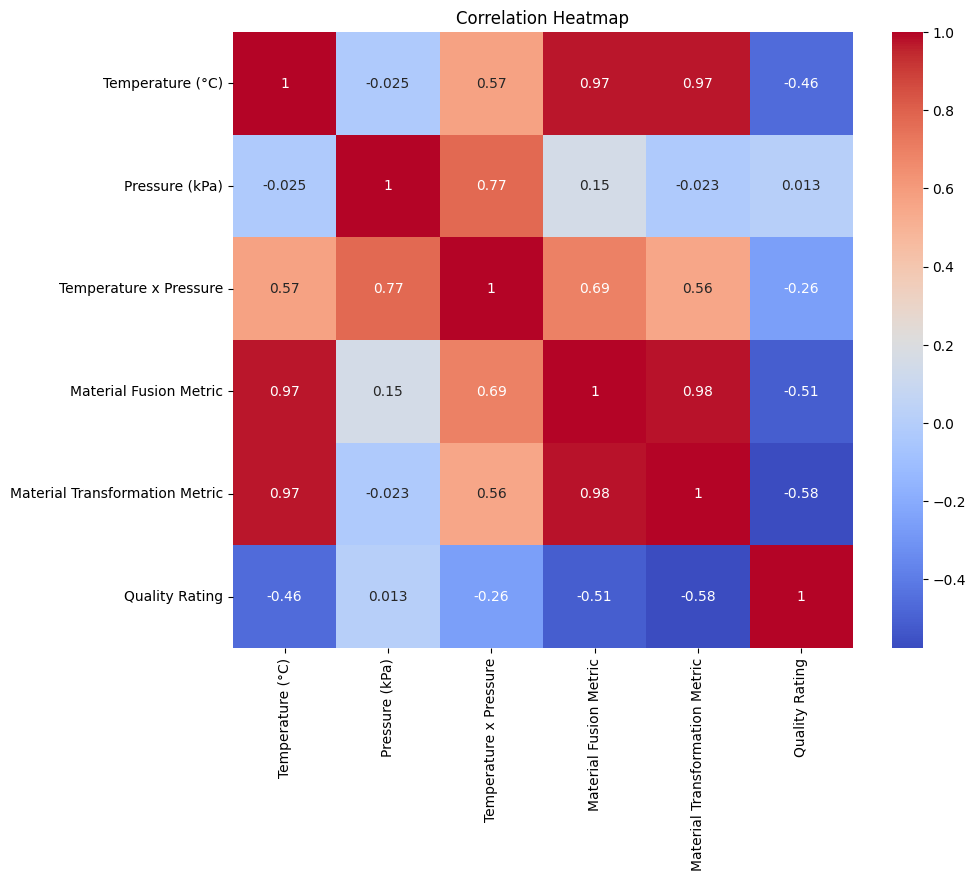

In [3]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Drop columns with less direct or inverse correlation and one of the columns with very high correlation with each other to avoid overfitting.

In [4]:
df = df.drop(columns=["Pressure (kPa)", "Temperature (°C)", "Material Fusion Metric"])
df

,Temperature x Pressure,Material Transformation Metric,Quality Rating
0,1688.769167,9.229576e+06,99.999971
1,3842.931469,1.435537e+07,99.985703
2,1729.823314,1.072839e+07,99.999758
3,4970.736918,9.125702e+06,99.999975
4,2918.345014,6.303792e+06,100.000000
...,...,...,...
3952,3417.596965,3.855501e+06,100.000000
3953,1640.516924,7.744742e+06,99.999997
3954,3956.304672,1.405957e+07,99.989318
3955,4977.234763,9.134036e+06,99.999975


### Prepare for training

In [5]:
x = df.drop(columns="Quality Rating").to_numpy()
y = df["Quality Rating"].to_numpy()
print("Features Shape: ", x.shape)
print("Labels: Shape", y.shape)

Features Shape:  (3957, 2)
Labels: Shape (3957,)


### Scale Dataset

In [6]:
# Z-score normalization for feature scaling
scaler = StandardScaler()

x_scaled = scaler.fit_transform(x)
x_scaled.shape

(3957, 2)

### Use `PolynomialFeatures()`

It makes the regression a polynomial regression

In [7]:
#Polynomial Transformation
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x_scaled)

### Split dataset into train and test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.2, random_state=42)

print("Training Data:", x_train.shape, y_train.shape)
print("Testing Data:", x_test.shape, y_test.shape)

Training Data: (3165, 10) (3165,)
Testing Data: (792, 10) (792,)


### Write the function to compute Cost

In [9]:
def cost_function(X, y, w, b, lambda_):
	m,n = X.shape

	cost_sum = 0.
	for i in range(m):
		f_wb = np.dot(X[i], w) + b
		cost = (f_wb - y[i])**2
		cost_sum += cost
	cost_sum = cost_sum/(2*m)
	
	reg_cost = 0.
	for j in range(n):
		penalty = w[j]**2
		reg_cost += penalty
	reg_cost = (lambda_/(2*m)) * reg_cost

	total_cost = cost_sum + reg_cost
	return total_cost

### Test Cost function

In [10]:
w_tmp = np.random.rand(x_train.shape[1])
b_tmp = np.random.rand()  
lambda_tmp = 1

cost = cost_function(x_train, y_train, w_tmp, b_tmp, lambda_tmp)
print("Cost:", cost)

Cost: 4420.815447285165


### Compute Gradient Term

In [11]:
def gradient_function(X, y ,w, b, lambda_):
	m = X.shape[0]
	n = len(w)
	dj_dw = np.zeros((n,))
	dj_db = 0.
	for i in range(m):
		err = (np.dot(w, X[i]) + b) - y[i]
		for j in range(n):
			dj_dw[j] += err * X[i, j] 
		dj_db += err
	dj_dw = dj_dw / m
	dj_db = dj_db / m

	for j in range(n):
		dj_dw[j] += lambda_/m * w[j]

	return dj_dw, dj_db

In [12]:
# test

### Compute Gradient Descent

In [13]:
def gradient_descent(X, y, w_in, b_in, alpha, cost_function, gradient_function, lambda_,  num_iters):
    
	J_history = []
	w_history = []

	w = copy.deepcopy(w_in)
	b = b_in

	for i in range(num_iters):
		dj_dw, dj_db = gradient_function(X, y, w, b, lambda_)
		w = w - (alpha * dj_dw)
		b = b - (alpha * dj_db)

		# Save cost J at each iteration
		if i < 100000:  # prevent resource exhaustion
			cost = cost_function(X, y, w, b, lambda_)
			J_history.append(cost)

		# Print cost every at intervals 10 times or as many iterations if < 10
		if i % math.ceil(num_iters / 10) == 0:
			w_history.append(w)
			print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}")
	return w, b, J_history, w_history  # return w and J, w history for graphing


### Increase Recursions limit to increase iterations

In [14]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())  # Check recursion limit

10000


### Train your model

In [15]:
a = np.shape(x_train)[1]
initial_w = np.random.rand(a)
initial_b = 0.

w,b,_,_= gradient_descent(x_train,y_train,initial_w,initial_b,
                          0.037,cost_function,gradient_function,0.9, num_iters= 5000)

Iteration    0: Cost  3471.75
Iteration  500: Cost    11.11
Iteration 1000: Cost    10.49
Iteration 1500: Cost    10.44
Iteration 2000: Cost    10.43
Iteration 2500: Cost    10.43
Iteration 3000: Cost    10.43
Iteration 3500: Cost    10.42
Iteration 4000: Cost    10.42
Iteration 4500: Cost    10.42


### Make predictions on the test set 

In [16]:
m = x_test.shape[0]

y_pred = np.zeros(m)
for i in range(m):
    y_pred[i] = np.dot(w, x_test[i]) + b

Calculate Model Accuracy Score(0.81 to 0.94 is good(will generalize well to unseen data))

In [17]:
r2 = r2_score(y_test, y_pred)
r2

0.8719271040394366

In [18]:
import joblib

model_params = {
    "w": w,
    "b": b,
    "scaler": scaler
}
joblib.dump(model_params, "PolyFromScratch.pkl")

['PolyFromScratch.pkl']